In [54]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### קריאה לקובץ נתונים ובדיקת עמודות

In [45]:
data = pd.read_csv("dataset.csv")
df = data.copy()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Prev_ownership   774 non-null    object 
 8   Curr_ownership   774 non-null    object 
 9   Area             1361 non-null   object 
 10  City             1500 non-null   object 
 11  Price            1500 non-null   float64
 12  Pic_num          1476 non-null   float64
 13  Cre_date         1500 non-null   object 
 14  Repub_date       1500 non-null   object 
 15  Description      1500 non-null   object 
 16  Color            787 non-null    object 
 17  Km            

In [47]:
def prepare_data(df):

    # Fix manufacturer name
    def fix_manufactor(string):
        try:
            if 'Lexsus' in string:
                return 'לקסוס'
            else:
                return string
        except:
            return string

    # Process the model name to remove the manufacturer
    def process_model(row):
        manufacturer = row['manufactor']
        model = row['model']
    
        # Check if manufacturer is in model
        if manufacturer in model:
            # Remove manufacturer from model
            model = model.replace(manufacturer, '').strip()
    
        # If model starts with a space, remove it
        if ' ' in model:
            return model.split(' ', 1)[0].strip()
    
        return model.strip()

    # Fix gear type
    def fix_gear(string):
        try:
            if 'לא מוגדר' in string or 'אוטומט' in string:
                return 'אוטומטית'
            
            else:
                return string
        except:
            return string

    # Fix engine capacity by removing commas and converting to integer        
    def fix_capacity(string):
        try:
            if ',' in string:
                cleaned_value = string.replace(',', '')
                return int(cleaned_value)
            
            else:
                return int(string)
            
        except:
            return string
    
    # Fix engine type       
    def fix_engine(string):
        try:
            if 'היבריד' in string:
                return 'היברידי'
            else:
                return string
        except:
            return string        
    
    # Fix ownership status
    def fix_ownership(value):
        if value in ['לא מוגדר', 'None']:
            return 'אחר'
    
        return value
    
    # Fix area names
    def fix_area(value):
        if pd.isnull(value):
            return 'לא ידוע'
        if value in 'None':
            return 'לא ידוע'
        if 'הוד' in value:
            return 'הוד השרון והסביבה'
        if 'חולון' in value:
            return 'חולון - בת ים'   
        if 'חיפה' in value:
            return 'חיפה וחוף הכרמל'
        if 'טבריה' in value:
            return 'טבריה והסביבה'
        if 'ירושלים' in value:
            return 'ירושלים והסביבה' 
        if 'מודיעין' in value:
            return 'מודיעין והסביבה'
        if 'נס' in value or 'רחובות' in value:
            return 'נס ציונה - רחובות'
        if 'גליל' in value:
            return 'גליל ועמקים'    
        if 'נתניה' in value:
            return 'נתניה והסביבה'
        if 'עמק' in value:
            return 'עמק יזרעאל' 
        if 'פרדס' in value:
            return 'פרדס חנה - כרכור'
        if 'פתח' in value:
            return 'פתח תקווה והסביבה'
        if 'ראש' in value:
            return 'ראש העין והסביבה'
        if 'ראשל"צ' in value:
            return 'ראשל"צ והסביבה' 
        if 'רמלה' in value:
            return 'רמלה - לוד'
        if 'רמת' in value:
            return 'רמת גן - גבעתיים'
        if 'רעננה' in value:
            return 'רעננה - כפר סבא' 
        if 'תל' in value:
            return 'תל אביב'     
        return value

    # Fix picture number, set to 0 if null
    def fix_pic_num(value):
        if pd.isnull(value):
            return 0
        return value

    # Determine if a car listing is reposted    
    def is_reposted(data, cre_date_col, repub_date_col):
        # Convert the columns to datetime, errors='coerce' will turn non-date values into NaT
        data[cre_date_col] = pd.to_datetime(data[cre_date_col], errors='coerce')
        data[repub_date_col] = pd.to_datetime(data[repub_date_col], errors='coerce')

        # Replace NaT values with "לא ידוע"
        data[cre_date_col] = data[cre_date_col].astype(object).where(data[cre_date_col].notna(), "לא ידוע")
        data[repub_date_col] = data[repub_date_col].astype(object).where(data[repub_date_col].notna(), "לא ידוע")

        # Calculate the difference in days, treating "לא ידוע" as 0
        data['days_diff'] = data.apply(
            lambda row: 0 if row[cre_date_col] == "לא ידוע" or row[repub_date_col] == "לא ידוע"
            else (row[repub_date_col] - row[cre_date_col]).days, axis=1)

        # Create the binary 'is_reposted' column
        data['is_reposted'] = (data['days_diff'] > 0).astype(int)

        # Drop the temporary 'days_diff' column
        data.drop(columns=['days_diff'], inplace=True)

        return data

    # Calculate the age of the car    
    def calculate_car_age(data, year_col, repub_date_col):
        # Calculate the age of the car in years
        data['Age'] = (datetime.today().year - data[year_col])

        return data
 
    # Check for positive and negative keywords in the description and gives each description value a numerical score   
    def check_keywords(text):
        num = 100
        try:
            positive_keywords = ["חדש", "מובילאיי", "חיישן", "מולטימדיה", "מטופל", "ללא תאונות", "מקוריים", "מקורי", "טוב", "חסכוני", "פרטית", "מורשה", "שמור"]
            negative_keywords = ["סריטות", "שריטות", "ליסינג", "מונית", "כתמי שמש", "שריטה", "מכה", "מכות"]

            for keyword in positive_keywords:
                if keyword in text:
                    num += 20

            for keyword in negative_keywords:
                if keyword in text:
                    num -= 20

            return num
        except Exception as e:
            return num
    
    # Fix color names   
    def fix_color(value):
        if pd.isnull(value):
            return 'לא ידוע' 
        if 'None' in value:
            return 'לא ידוע'
        if 'כסף מטלי' in value:
            return 'כסוף מטאלי'
        return value
    
    # Fix 'Km' values 
    def fix_Km(data, age_col, km_col):
        # Replace non-numeric strings and commas in 'Km' values
        data[km_col] = data[km_col].astype(str).replace('None', '').str.replace(',', '')
    
        # Convert 'Km' to numeric, setting errors='coerce' to handle non-numeric entries
        data[km_col] = pd.to_numeric(data[km_col], errors='coerce')
    
        # Multiply 'Age' by 20000
        data['Km_fixed'] = data[age_col] * 20000

        # Replace NaN and 0 values in 'Km' with the calculated values
        data[km_col] = np.where((data[km_col].isna()) | (data[km_col] == 0) | (data[km_col] < 10000 ), data['Km_fixed'], data[km_col])

        # Drop the temporary 'Km_fixed' column
        data.drop(columns=['Km_fixed'], inplace=True)

        return data

    # Remove columns with high percentage of missing values
    def remove_high_missing_cols(df, threshold=60):
        # Calculate the percentage of missing values for each column
        missing_values_percentage = (df.isnull().sum() / len(df)) * 100
    
        # Identify columns to drop
        cols_to_drop = missing_values_percentage[missing_values_percentage > threshold].index
        
        # Drop the columns
        df_cleaned = df.drop(columns=cols_to_drop)
    
        return df_cleaned
    
    # Apply the various fixing functions to the dataframe columns    
    df['manufactor'] = df['manufactor'].apply(fix_manufactor)
    df['model'] = df.apply(process_model, axis=1)
    df['Gear'] = df['Gear'].apply(fix_gear)
    df['capacity_Engine'] = df['capacity_Engine'].apply(fix_capacity)
    df['Engine_type'] = df['Engine_type'].apply(fix_engine)
    df['Prev_ownership'] = df['Prev_ownership'].apply(fix_ownership)
    df['Curr_ownership'] = df['Curr_ownership'].apply(fix_ownership)
    df['Area'] = df['Area'].apply(fix_area)
    df['Pic_num'] = df['Pic_num'].apply(fix_pic_num)
    df['Pic_num'] = df['Pic_num'].astype(int)
    df = calculate_car_age(df,'Year', 'Repub_date')
    df = is_reposted(df,'Cre_date', 'Repub_date') #create a new column instead of the dates columns    
    df['Description'] = df['Description'].apply(check_keywords) 
    df['Color'] = df['Color'].apply(fix_color)
    df = fix_Km(df,'Age', 'Km')
    df = remove_high_missing_cols(df, threshold=60)
    
    # remove duplicates cols
    df.drop_duplicates(subset=df.columns.difference(['Area','City']))

    # missing values
    df['Gear'] = df['Gear'].fillna('אוטומטית')    
    df['Prev_ownership'] = df['Prev_ownership'].fillna('אחר')  
    df['Curr_ownership'] = df['Curr_ownership'].fillna('אחר')  
    df = df.dropna(subset=['Engine_type'])
    
    # Define the features to handle outliers
    df1 = df.copy()
    features = ['Hand','Pic_num','Description']

    # Remove outliers using IQR method
    for i in features:
        if np.issubdtype(df1[i].dtype, np.number):  # Check if column contains numeric data
            Q1 = df1[i].quantile(0.25)
            Q3 = df1[i].quantile(0.75)
            IQR = Q3 - Q1
            initial_count = df1.shape[0]
            df1 = df1[(df1[i] >= (Q1 - 1 * IQR)) & (df1[i] <= (Q3 + 1 * IQR))]
            final_count = df1.shape[0]
            df1 = df1.reset_index(drop=True)

    df = df1  


    # The arrangement of the columns, and the predicted column shift to the right
    order_columns = ['manufactor','Year','model','Hand','Gear','capacity_Engine', 'Engine_type','Prev_ownership','Curr_ownership','Area','City','Pic_num','Description','Color','Km','Age','is_reposted','Price']
    df = df[order_columns]

    return df

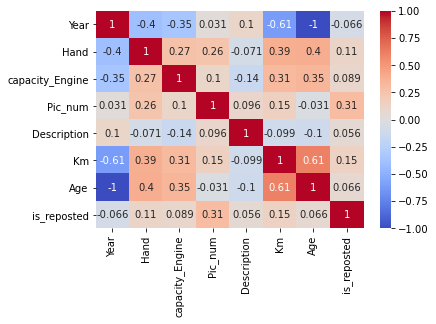

<Figure size 2520x2520 with 0 Axes>

In [51]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("dataset.csv")
df = data.copy()

train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
train_data = prepare_data(train_data)
test_data = prepare_data(test_data)

frequent_value = train_data['capacity_Engine'].mode()[0]

#filling missing values and outliers with the mode value (from train data) for the engine capacity 
train_data['capacity_Engine'] = train_data['capacity_Engine'].fillna(frequent_value)
# Replace outliers for train data
train_data.loc[(train_data['capacity_Engine'] < 900) | (train_data['capacity_Engine'] > 4000), 'capacity_Engine'] = frequent_value
test_data['capacity_Engine'] = test_data['capacity_Engine'].fillna(frequent_value)
# Replace outliers for test data
test_data.loc[(test_data['capacity_Engine'] < 900) | (test_data['capacity_Engine'] > 4000), 'capacity_Engine'] = frequent_value

# Separate the features and target for training data
X_train = train_data.drop(['Price'], axis=1)
y_train = train_data['Price']

# Separate the features and target for test data
X_test = test_data.drop(['Price'], axis=1)
y_test = test_data['Price']


# We will check the correlation in the columns
spearman_X_train = X_train.corr(method = 'spearman')
sns.heatmap(spearman_X_train, cmap='coolwarm', center=0, annot = True)
plt.figure(figsize=(35,35))


# There is a high correlation between the age of the car, the Km and the year (fairly logical) 
# therefore in order to optimize the model we decided to drop the columns Age and Km.
# Also, we assume that the City and Area not affecting the price so we decided not to use it

# Define categorical and numerical columns
categorical_columns = ['manufactor','model','Gear','Engine_type','Prev_ownership','Curr_ownership','Color']
numerical_columns = ['Year', 'Hand','capacity_Engine','Pic_num','Description','is_reposted']

# Create the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('E', ElasticNet())
])

# Define the parameter grid for hyperparameter search
param_grid = {
    'E__alpha': [0.05, 0.06, 0.07, 0.09, 0.1, 0.5, 1.0, 5.0, 5.5],
    'E__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create the GridSearchCV object with 10-fold cross-validation
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)

# # Calculate and print performance metrics
# mse_test = mean_squared_error(y_test, y_pred)
# rmse_test = np.sqrt(mse_test)

# # Calculate RMSE on training set for comparison
# y_train_pred = best_model.predict(X_train)
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)

### חמשת המאפיינים בעלי ההשפעה הגדולה ביותר על החיזוי

In [52]:
# Fit the best model on the training data again (if not already fitted)
best_model.fit(X_train, y_train)

# Get the feature importances (coefficients) from the ElasticNet model
importances = best_model.named_steps['E'].coef_

# Extract feature names from the preprocessor
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
try:
    onehot_feature_names = encoder.get_feature_names_out(categorical_columns)
except AttributeError:
    onehot_feature_names = encoder.get_feature_names(categorical_columns)

all_feature_names = np.concatenate([numerical_columns, onehot_feature_names])

# Create a DataFrame to visualize the feature importances
feature_importances = pd.DataFrame(importances, index=all_feature_names, columns=['importance'])

# Sort by absolute value of importance (magnitude)
feature_importances['abs_importance'] = np.abs(feature_importances['importance'])
sorted_importances = feature_importances.sort_values(by='abs_importance', ascending=False)

# Display the top 5 features and their direction (positive/negative)
top_features = sorted_importances.head(5)

# Identify positive and negative impact
top_features['impact'] = top_features['importance'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

print("Top 5 Most Important Features:")
print(top_features[['importance', 'impact']])


Top 5 Most Important Features:
                     importance    impact
model_חיפושית      21692.406750  Positive
model_לנסר        -19708.901992  Negative
model_325          19595.625951  Positive
manufactor_ב.מ.וו  17569.809132  Positive
Year               14555.281490  Positive


### מדדי ביצועי המודל

In [55]:
def score_mse_model(y_test, y_pred, model_name):
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)

    print(f"Model test results: {model_name} ,MSE: {np.round(MSE, 2)} ,RMSE: {np.round(RMSE, 2)} ,MAE:{np.round(MAE, 2)}")
    
# Model performance evaluation on test sample
score_mse_model(y_test, y_pred, 'E')

Model test results: E ,MSE: 154443729.17 ,RMSE: 12427.54 ,MAE:9768.72
